In [5]:
import numpy as np
import gym
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
class QLearning(object):
    def __init__(self,env,cfg): #相当于创造智能体的基本参数，传入的参数包含了cfg和环境env
        self.Index_Precision = cfg.percision #设置数据离散化程度，数值越大离散化精度越高
        self.n_actions = env.action_space.n
        self.lr = cfg.lr  # 学习率
        self.gamma = cfg.gamma  #折扣率
        self.epsilon = cfg.epsilon_start #贪心策略函数
        self.sample_count = 0  #控制贪心的训练样本次数
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table = np.zeros((int(math.pow(self.Index_Precision,4))+1,2))
    #离散化数据
    def linespace_n(self,min,max,Index_Percision):
        return np.linspace(min,max,Index_Percision + 1)[1:-1]
    
    def state_id(self,state):
        id = [np.digitize(state[0], bins=self.linespace_n(-2.4, 2.4, self.Index_Precision)),
               np.digitize(state[1], bins=self.linespace_n(-3.0, 3.0, self.Index_Precision)),
               np.digitize(state[2], bins=self.linespace_n(-0.41, 0.41, self.Index_Precision)),
               np.digitize(state[3], bins=self.linespace_n(-2.0, 2.0, self.Index_Precision))]
        return sum([x * (self.Index_Precision ** i) for i, x in enumerate(id)])
    
    #选择动作的策略函数
    def sample_action(self,state):
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) # epsilon是会递减的，这里选择指数递减
        # e-greedy 策略
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[self.state_id(state)]) # 选择Q(s,a)最大对应的动作
        else:
            action = np.random.choice(self.n_actions) # 随机选择动作
        return action
    #测试时的选择函数
    def predict_action(self,state):
        action = np.argmax(self.Q_table[self.state_id(state)])
        return action
    
    #Q表更新函数
    def update(self, state, action, reward, observation,terminated):
        Q_predict = self.Q_table[self.state_id(state)][action] #根据Q表得到的预测值
        if terminated:
            Q_target = reward -125
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[self.state_id(observation)]) 
        self.Q_table[self.state_id(state)][action] += self.lr * (Q_target - Q_predict)


In [7]:
#训练Q表函数
def train(cfg,env,agent):
    print('开始训练！')
    rewards = []  # 记录奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录每个回合的奖励
        state = env.reset()  # 重置环境,即开始新的回合(初始化)
        while True:
            action = agent.sample_action(state)  # 根据算法依照当前状态采样一个动作
            observation, reward, terminated, info = env.step(action)  # 根据采样到的动作与环境进行一次动作交互
            agent.update(state, action, reward, observation,terminated)  # Q学习算法更新
            state = observation  # 更新状态
            ep_reward += reward  #每回合的奖励累计
            if terminated:
                break
        rewards.append(ep_reward)
        if (i_ep+1)%20==0:#20次一次输出
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.1f},Epsilon:{agent.epsilon:.3f}")
    print('完成训练！')
    return {"rewards":rewards}#返回奖励队列
#测试Q表函数   
def test(cfg,env,agent,Out=True):
    print('开始测试！')
    rewards = []  # 记录所有回合的奖励
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset()  # 重置环境, 重新开一局（即开始新的一个回合）
        while True:
            action = agent.predict_action(state)  # 根据算法选择一个动作
            if Out:
                env.render()
            observation, reward, terminated, info = env.step(action)  # 与环境进行一个交互
            state = observation  # 更新状态
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        print(f"回合数：{i_ep+1}/{cfg.test_eps}, 奖励：{ep_reward:.1f}")
    print('完成测试！')
    if Out:
        env.close()
    return {"rewards":rewards}

开始训练！
回合：20/200，奖励：20.0,Epsilon:0.339
回合：40/200，奖励：116.0,Epsilon:0.074
回合：60/200，奖励：101.0,Epsilon:0.019
回合：80/200，奖励：147.0,Epsilon:0.011
回合：100/200，奖励：165.0,Epsilon:0.010
回合：120/200，奖励：132.0,Epsilon:0.010
回合：140/200，奖励：137.0,Epsilon:0.010
回合：160/200，奖励：125.0,Epsilon:0.010
回合：180/200，奖励：150.0,Epsilon:0.010
回合：200/200，奖励：173.0,Epsilon:0.010
完成训练！
开始测试！
回合数：1/10, 奖励：135.0
回合数：2/10, 奖励：156.0
回合数：3/10, 奖励：167.0
回合数：4/10, 奖励：146.0
回合数：5/10, 奖励：150.0
回合数：6/10, 奖励：134.0
回合数：7/10, 奖励：150.0
回合数：8/10, 奖励：127.0
回合数：9/10, 奖励：157.0
回合数：10/10, 奖励：130.0
完成测试！


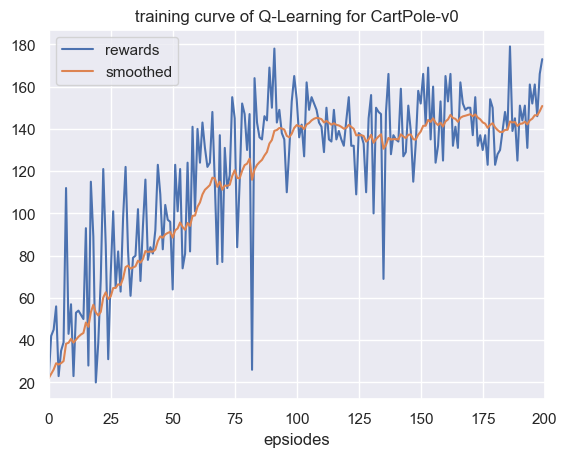

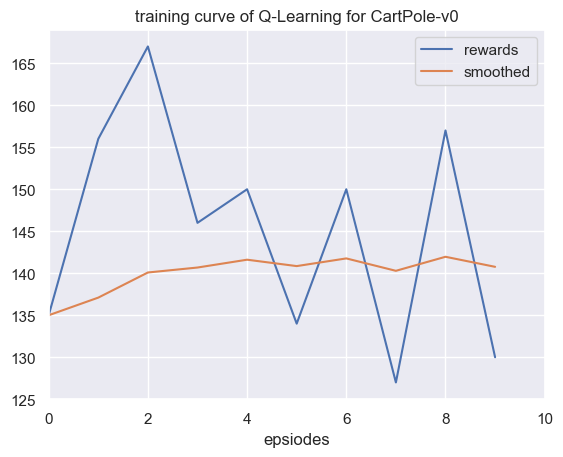

In [8]:
#创建智能体和环境
def env_agent_config(cfg,seed=1):
    env = gym.make(cfg.env_name)  
    agent = QLearning(env,cfg)
    return env,agent

#参数定义
class Config:
    def __init__(self):
        self.env_name = 'CartPole-v0' # 环境名称
        self.algo_name = 'Q-Learning' # 算法名称
        self.train_eps = 200 # 训练回合数
        self.test_eps = 10 # 测试回合数
        self.epsilon_start = 0.95 #  e-greedy策略中epsilon的初始值
        self.epsilon_end = 0.01 #  e-greedy策略中epsilon的最终值
        self.epsilon_decay = 1000 #  e-greedy策略中epsilon的衰减率
        self.gamma = 0.95 # 折扣因子
        self.lr = 0.1 # 学习率
        self.seed = 1 # 随机种子
        self.percision = 9 #离散精确程度

#绘制奖励变化曲线
def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')     
    plt.legend()

def smooth(data, weight=0.9):  
    '''用于平滑曲线
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

#开始训练
cfg = Config()
#创建智能体和环境
env,agent = env_agent_config(cfg)
env.seed = cfg.seed
res_dic = train(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"training curve of {cfg.algo_name} for {cfg.env_name}")

res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"training curve of {cfg.algo_name} for {cfg.env_name}")